In [1]:
import warnings
#warnings.filterwarnings('ignore')
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import seaborn as sns
from joblib import Parallel, delayed
import multiprocessing

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove URLs
    text = re.sub(r'(?:https?:\/\/(?:www\.|(?!www))|www\.)[\w\-\.\+/?=&#@:%~]+', 'URL', text)
    # Remove punctuation and special characters
    text = re.sub(r'[\W_]+', ' ', text)
    # Tokenize and remove stop words
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Load data
def preprocess_data_from_file(filepath):
    # Read the file
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    labels = []
    texts = []
    for line in lines:
        label, text = line.split(' ', 1)
        label = int(label.split('__label__')[1])
        labels.append(label)
        texts.append(text.strip())
    
    # Parallelize the preprocessing of text
    num_cores = multiprocessing.cpu_count()
    processed_texts = Parallel(n_jobs=num_cores)(delayed(preprocess_text)(text) for text in texts)
    
    # Create DataFrame
    df = pd.DataFrame({'label': labels, 'text': processed_texts})
    
    return df

In [3]:
# Load and preprocess data
train_filepath = 'train.3270.txt'
df_train = preprocess_data_from_file(train_filepath)

# Split data into features and labels
X = df_train['text']
y = df_train['label']

del lemmatizer, stop_words, stopwords, train_filepath, df_train

In [4]:
X[0], y[0]

('stuning even non gamer sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen',
 2)

In [5]:
# Vectorize text data using CountVectorizer
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(X)

# Get term frequencies
term_frequencies = count_matrix.sum(axis=0).A1
terms = count_vectorizer.get_feature_names_out()

# Create a DataFrame of terms and their frequencies
term_freq_df = pd.DataFrame({'term': terms, 'frequency': term_frequencies})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

# Display the top 20 terms
print(term_freq_df.head(20))

del count_vectorizer, count_matrix, term_frequencies, terms

          term  frequency
1437      book       2383
8941       one       1417
7534      like        975
8436     movie        961
5706     great        882
10375     read        857
5615      good        845
13146     time        802
14494    would        766
5494       get        723
10396   really        533
12386    story        526
7713      love        518
4995     first        504
14258     well        472
7838      make        468
4484      even        464
8451      much        463
10007  product        451
14465     work        424


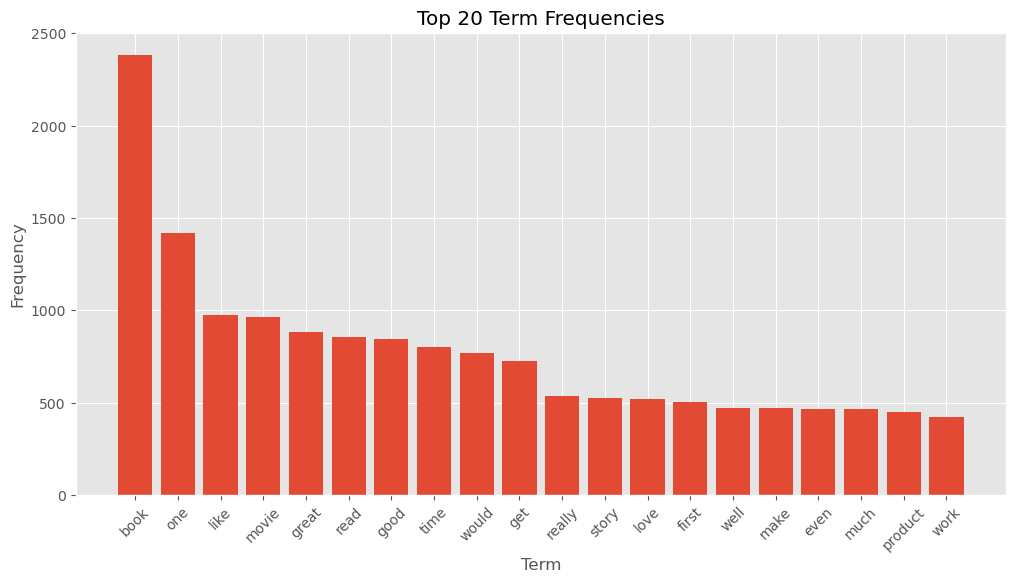

In [9]:
# Plot term frequencies
plt.figure(figsize=(12, 6))
plt.bar(term_freq_df['term'].head(20), term_freq_df['frequency'].head(20))
plt.xticks(rotation=45)
plt.title('Top 20 Term Frequencies')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.show()

In [ ]:
%matplotlib qt

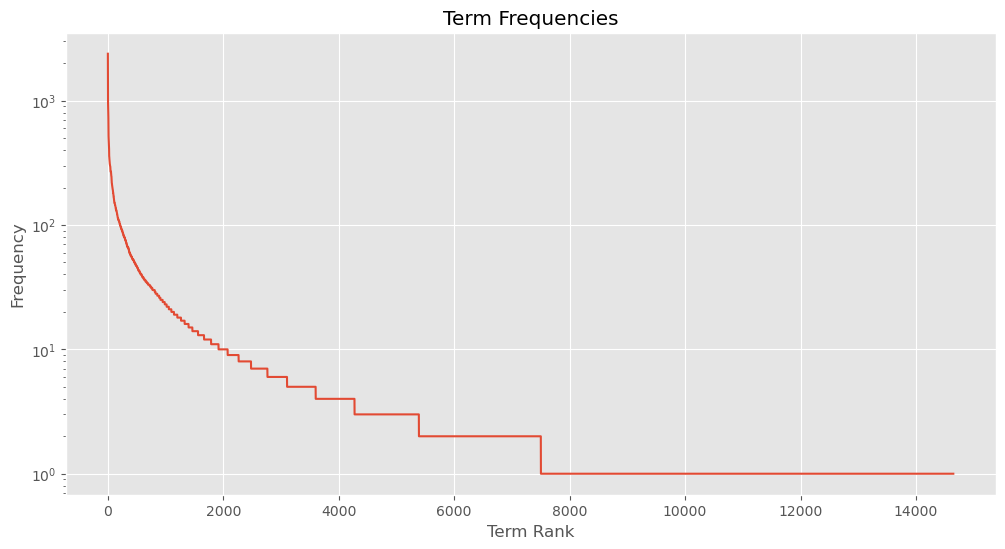

In [10]:
# Plot term frequencies
plt.figure(figsize=(12, 6))
plt.plot(term_freq_df['frequency'].values)
#plt.plot(term_freq_df['frequency'].values[25000:26000])
plt.title('Term Frequencies')
plt.xlabel('Term Rank')
plt.ylabel('Frequency')
plt.yscale('log')  # Optional: use logarithmic scale for better visualization
plt.show()

In [ ]:
%matplotlib inline

In [18]:
# Filter terms with frequency >= 2
# Determine max_features based on the filtered terms
max_features = len(term_freq_df[term_freq_df['frequency'] >= 2])

# Step 3: Initialize and fit the TfidfVectorizer with stop_words and max_features
vectorizer = TfidfVectorizer(max_features=max_features)
tfidf_matrix = vectorizer.fit_transform(X)

# Convert the TF-IDF matrix to a dense matrix
dense_tfidf = tfidf_matrix.todense()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dense_tfidf, y, test_size=0.2, random_state=42)

del max_features, vectorizer, tfidf_matrix, dense_tfidf

In [19]:
import gc
gc.collect()

38

In [14]:
# Step 5: Build the Bidirectional LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Input layer
model.add(Dense(128, activation='relu'))  # Dense layer as an alternative to embedding
model.add(Dense(64, activation='relu'))  # Additional Dense layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Step 6: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=100, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/2
27/27 [==============================] - 1s 21ms/step - loss: 0.3623 - accuracy: 0.5119 - val_loss: -0.3585 - val_accuracy: 0.5229
Epoch 2/2
21/21 [==============================] - 0s 3ms/step - loss: -3.3801 - accuracy: 0.5229
Test Accuracy: 0.5229358077049255


In [ ]:
# Step 4: Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train.asarray(), y_train)

# Step 5: Make predictions and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')